# Imports and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
df_ml = pd.read_csv('ML-EdgeIIoT-dataset.csv', low_memory=False)
df_dl = pd.read_csv('DNN-EdgeIIoT-dataset.csv', low_memory=False)

# Deep Learning

In [140]:
columns_to_drop = ['Attack_label', 'frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4', 'arp.src.proto_ipv4', 
                  'mqtt.msg_decoded_as', 'mqtt.conack.flags', 'mqtt.msg', 'mqtt.topic', 'mbtcp.trans_id', 'mbtcp.unit_id',
                   'http.file_data','http.content_length', 'http.request.uri.query', 'http.request.method', 'http.referer',
                   'http.request.full_uri', 'http.request.version', 'http.response', 'http.tls_port', 'tcp.options', 
                   'tcp.payload', 'dns.qry.name.len', 'tcp.srcport', 'mqtt.protoname', 'dns.qry.name.len']

df_dl_clean = df_dl.copy()
df_dl_clean = df_dl_clean.drop(columns=columns_to_drop, axis=1)


for col in df_dl_clean.columns:
    if col != 'Attack_type':
        try:
            df_dl_clean[col] = df_dl_clean[col].astype(float)
        except:
            print(col)
df_dl_clean

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,icmp.unused,tcp.ack,tcp.ack_raw,tcp.checksum,tcp.connection.fin,...,mqtt.conflag.cleansess,mqtt.conflags,mqtt.hdrflags,mqtt.len,mqtt.msgtype,mqtt.proto_len,mqtt.topic_len,mqtt.ver,mbtcp.len,Attack_type
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.153346e+09,47892.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.447945e+08,16077.0,0.0,...,1.0,2.0,16.0,12.0,1.0,4.0,0.0,4.0,0.0,Normal
2,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,62675.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,54469.0,0.0,...,0.0,0.0,32.0,2.0,2.0,0.0,0.0,0.0,0.0,Normal
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.447945e+08,53812.0,0.0,...,0.0,0.0,48.0,39.0,3.0,0.0,24.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219196,0.0,0.0,31814.0,45620.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS_ICMP
2219197,0.0,0.0,27718.0,45636.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS_ICMP
2219198,0.0,0.0,18502.0,45672.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS_ICMP
2219199,0.0,0.0,1862.0,45737.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS_ICMP


In [141]:
scaler = StandardScaler()
feature_columns = [col for col in df_dl_clean.columns if col != 'Attack_type']
df_dl_clean[feature_columns] = scaler.fit_transform(df_dl_clean[feature_columns])

In [142]:
X = df_dl_clean.drop('Attack_type', axis=1)
y = df_dl_clean['Attack_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Deep Neural Network

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [118]:
class DNNMulticlass(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(36, 200) # 36 features => X_train.shape[1]
        self.layer2 = nn.Linear(200, 200)
        self.layer3 = nn.Linear(200, 200)
        self.out_layer = nn.Linear(200, 15) # 15 classifications =>  y_train.value_counts()

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))  
        x = self.out_layer(x) 
        return x

In [110]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [143]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

class_mapping = {"Normal": 0, "DDoS_UDP": 1, "DDoS_ICMP": 2, "Ransomware": 3, "DDoS_HTTP": 4, "SQL_injection": 5,
                "Uploading": 6, "DDoS_TCP": 7, "Backdoor": 8, "Vulnerability_scanner": 9, "Port_Scanning": 10,
                "XSS": 11, "Password": 12, "MITM": 13, "Fingerprinting": 14}

y_train_encoded = y_train.replace(class_mapping)
y_train_tensor = torch.tensor(y_train_encoded.values, dtype=torch.long)

y_test_encoded = y_test.replace(class_mapping)
y_test_tensor = torch.tensor(y_test_encoded.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=250)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=250)

In [144]:
# Training
model_dnn = DNNMulticlass()
early_stopping = EarlyStopping(patience=5, delta=0.001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_dnn.parameters(), lr=0.001)

training_losses = []
validation_losses = []

epochs = 50 # Training rounds
for epoch in range(epochs): 
    model_dnn.train()
    train_loss = 0.0
    for inputs, labels in train_loader:

        optimizer.zero_grad()

        # Feed forward + backpropogate
        outputs = model_dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation
    model_dnn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model_dnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print('Finished Training')

Epoch [1/50], Training Loss: 0.2782, Validation Loss: 0.2216
Epoch [2/50], Training Loss: 0.2044, Validation Loss: 0.2504
Epoch [3/50], Training Loss: 0.1931, Validation Loss: 0.2160
Epoch [4/50], Training Loss: 0.1839, Validation Loss: 0.2778
Epoch [5/50], Training Loss: 0.1808, Validation Loss: 0.3934
Epoch [6/50], Training Loss: 0.1784, Validation Loss: 0.1697
Epoch [7/50], Training Loss: 0.1771, Validation Loss: 0.2446
Epoch [8/50], Training Loss: 0.1764, Validation Loss: 0.1972
Epoch [9/50], Training Loss: 0.1774, Validation Loss: 0.1818
Epoch [10/50], Training Loss: 0.1762, Validation Loss: 0.1734
Epoch [11/50], Training Loss: 0.1801, Validation Loss: 0.1990
Early stopping triggered
Finished Training


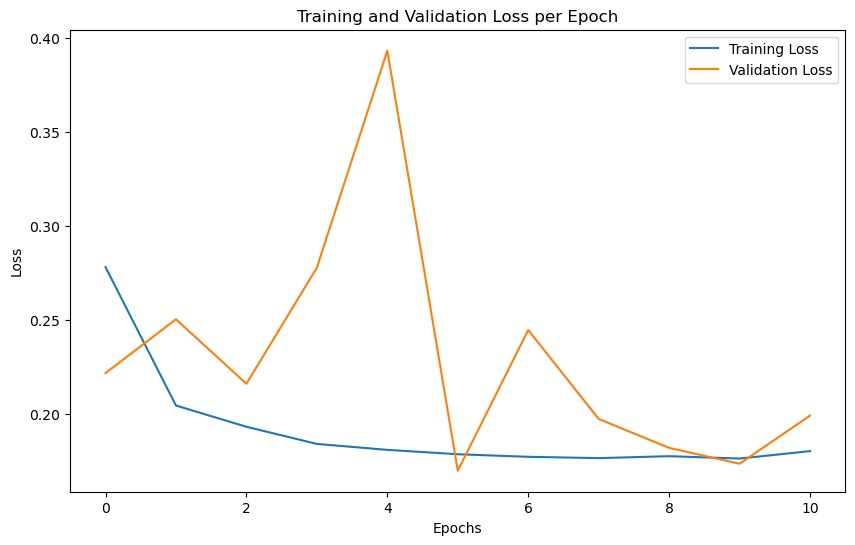

In [145]:
# Get the training and validation graphs

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [146]:
# Evaluations
model_dnn.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_dnn(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max logit
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_predictions)

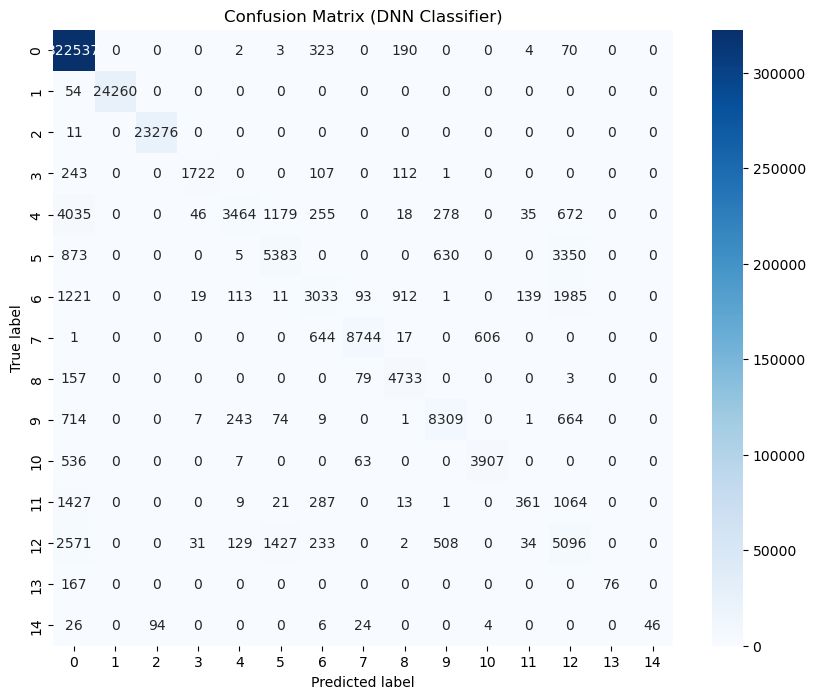

In [147]:
plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix (DNN Classifier)')

plt.show()

In [148]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [149]:
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9349
Precision: 0.9322
Recall: 0.9349
F1 Score: 0.9284


In [153]:
model_dnn.eval()

all_probabilities = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_dnn(inputs)
        probabilities = F.softmax(outputs, dim=1)
        all_probabilities.extend(probabilities.numpy())
        all_labels.extend(labels.numpy())

all_probabilities = np.array(all_probabilities)
all_labels = np.array(all_labels)

classes = np.arange(15)  # 15 classes
y_test_binarized = label_binarize(all_labels, classes=classes)

auc = roc_auc_score(y_test_binarized, all_probabilities, multi_class='ovr')

print(f"AUC (One-vs-Rest): {auc:.2f}")

AUC (One-vs-Rest): 0.99


In [183]:
for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0
    TNR = TN / (TN + FP) if TN + FP > 0 else 0

    metrics_per_class[i] = {
        "True Positive Rate (TPR)": round(TPR, 2),
        "False Positive Rate (FPR)": round(FPR, 2),
        "False Negative Rate (FNR)": round(FNR, 2),
        "True Negative Rate (TNR)": round(TNR, 2)
    }

metrics_per_class

{0: {'True Positive Rate (TPR)': 1.0,
  'False Positive Rate (FPR)': 0.1,
  'False Negative Rate (FNR)': 0.0,
  'True Negative Rate (TNR)': 0.9},
 1: {'True Positive Rate (TPR)': 1.0,
  'False Positive Rate (FPR)': 0.0,
  'False Negative Rate (FNR)': 0.0,
  'True Negative Rate (TNR)': 1.0},
 2: {'True Positive Rate (TPR)': 1.0,
  'False Positive Rate (FPR)': 0.0,
  'False Negative Rate (FNR)': 0.0,
  'True Negative Rate (TNR)': 1.0},
 3: {'True Positive Rate (TPR)': 0.79,
  'False Positive Rate (FPR)': 0.0,
  'False Negative Rate (FNR)': 0.21,
  'True Negative Rate (TNR)': 1.0},
 4: {'True Positive Rate (TPR)': 0.35,
  'False Positive Rate (FPR)': 0.0,
  'False Negative Rate (FNR)': 0.65,
  'True Negative Rate (TNR)': 1.0},
 5: {'True Positive Rate (TPR)': 0.53,
  'False Positive Rate (FPR)': 0.01,
  'False Negative Rate (FNR)': 0.47,
  'True Negative Rate (TNR)': 0.99},
 6: {'True Positive Rate (TPR)': 0.4,
  'False Positive Rate (FPR)': 0.0,
  'False Negative Rate (FNR)': 0.6,
  'Tru